In [1]:
import pandas as pd
from datetime import timedelta


signals = pd.read_csv('4h_hybrid_signals.csv', parse_dates=['timestamp'])[['timestamp','open', 'high', 'low','volume' ,'close', 'Donchian_High','Donchian_Low','VWAP','Moving_Avg','Breadth_Indicator','Signal','Hybrid_signal']]
df = pd.read_csv('ohlc_1m_data_last_day.csv', parse_dates=['timestamp'])


In [30]:
import time
from turtle import back
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

def ledger(signals, df, time_frame='4H'):
    """
    This function takes a dataframe of signals which is 4h interval data and df which is 1min interval data.
    """
    signals = signals
    df_1min = df
    action = []
    signal = []
    date_time = []
    buy_price = []
    sell_price = []
    pnl = []
    transaction_fee = 0.07 / 100
    profit_percentage = 0.05
    stop_loss_percentage = 0.02
    next_trade_time = None  # To store the time of the next trade

    def calculate_levels(buy, direction):
        if direction == 1:
            tp_price = buy + (buy * profit_percentage)
            sl_price = buy - (buy * stop_loss_percentage)
        elif direction == -1:
            tp_price = buy - (buy * profit_percentage)
            sl_price = buy + (buy * stop_loss_percentage)
        else:
            tp_price = sl_price = np.nan
        return tp_price, sl_price

    for i in range(len(signals)):
        if len(action) == 0 or (next_trade_time is not None and signals['timestamp'][i] >= next_trade_time):
            # Check and open a trade in the signal's direction
            if signals['Signal'][i] != 0:
                action.append(signals['Signal'][i])
                date_time.append(signals['timestamp'][i])
                buy_price.append(signals['open'][i])
                buy = signals['open'][i]
                if signals['Signal'][i] == 1:
                    signal.append('Buy')
                elif signals['Signal'][i] == -1:
                    signal.append('Sell')
                sell_price.append(np.nan)
                pnl.append(np.nan)
                next_trade_time = None
                tp_price, sl_price = calculate_levels(buy, signals['Signal'][i])
        else:
            if action[-1] == signals.iloc[i].Signal or signals['Signal'][i] == 0:
                if action[-1] == 1:
                    tp_price, sl_price = calculate_levels(buy, 1)
                elif action[-1] == -1:
                    tp_price, sl_price = calculate_levels(buy, -1)
                else:
                    continue 

                
                if i + 1 < len(signals):
                    next_signal_date = signals.loc[i + 1, 'timestamp']
                else:
                    next_signal_date = df_1min['timestamp'].max()

                end_datetime = signals.iloc[i]['timestamp']
                current_datetime = end_datetime - timedelta(hours=int(time_frame[0]))
                df_1min_slice = df_1min[(df_1min['timestamp'] >= current_datetime) & (df_1min['timestamp'] <= end_datetime)]
                df_1min_slice.reset_index(drop=True, inplace=True)

                for j in df_1min_slice.iterrows():
                    if j[1].high > tp_price and action[-1] == 1:
                        # Take profit
                        time = j[1].timestamp
                        sell_price.append(j[1].high)
                        action.append(action[-1])
                        signal.append('TP Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].low < sl_price and action[-1] == 1:
                        # Stop loss
                        time = j[1].timestamp
                        sell_price.append(j[1].low)
                        signal.append('SL Hit')
                        action.append(action[-1])
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].low < tp_price and action[-1] == -1:
                        # Take profit
                        time = j[1].timestamp
                        sell_price.append(j[1].low)
                        action.append(action[-1])
                        signal.append('TP Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].high > sl_price and action[-1] == -1:
                        # Stop loss
                        time = j[1].timestamp
                        sell_price.append(j[1].high)
                        action.append(action[-1])
                        signal.append('SL Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
            else:
                if action[-1] in ['tp hit', 'sl hit']:
                    if signals['Signal'][i] == 0:
                        continue  # Ignore if the new signal is 0
                    action.append(signals['Signal'][i])
                    date_time.append(signals['timestamp'][i])
                    buy_price.append(signals['open'][i])
                    signal.append('Buy')
                    buy = signals['open'][i]
                    sell_price.append(np.nan)
                    pnl.append(np.nan)
                    next_trade_time = None
                else:
                    action.append(signals['Signal'][i])
                    date_time.append(signals['timestamp'][i])
                    sell_price.append(signals['open'][i])
                    buy = signals['open'][i]
                    if signals['Signal'][i] == 1:
                        signal.append('Buy')
                    elif signals['Signal'][i] == -1:
                        signal.append('Sell')
                    buy_price.append(np.nan)
                    pnl.append(np.nan)

                    action.append(signals['Signal'][i])
                    date_time.append(signals['timestamp'][i])
                    buy_price.append(signals['open'][i])
                    buy = signals['open'][i]
                    if signals['Signal'][i] == 1:
                        signal.append('Buy')
                    elif signals['Signal'][i] == -1:
                        signal.append('Sell')
                    sell_price.append(np.nan)
                    pnl.append(np.nan)
                    
    # Creating the resulting dataframe
    ledger_df = pd.DataFrame({
        'date_time': date_time, 
        'signal': signal, 
        'action': action, 
        'buy_price': buy_price, 
        'sell_price': sell_price, 
        'pnl': pnl
    })
    ledger_df['action'] = ledger_df['action'].replace({1: 'Buy', -1: 'Sell', 0: 'Hold'})
    ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')
    ledger_df['signal'] = ledger_df['signal'].replace({1: 'Buy', -1: 'Sell', 0: 'Hold'})
    ledger_df['action'] = ledger_df['action'].replace({'Buy': 'Long', 'Sell': 'Short'})

    # Function to calculate PnL and balance
    def calculate_pnl_and_balance(df):
        balance = 1000  # Starting balance
        balances = []  # List to store balance after each transaction

        for index, row in df.iterrows():
            buy_price = float(row['buy_price'])
            sell_price = float(row['sell_price'])

            if pd.isna(sell_price) or pd.isna(buy_price):
                balances.append(balance)  # No change in balance
                continue

            if df.iloc[index-1]['signal'] == 'Buy':  # Long
                pnl_percent = ((sell_price - buy_price) / buy_price) * 100
            elif df.iloc[index-1]['signal'] == 'Sell':  # Short
                pnl_percent = ((buy_price - sell_price) / buy_price) * 100
            else:
                pnl_percent = 0

            pnl_change = balance * (pnl_percent / 100)  
            balance += pnl_change  
            balances.append(balance)  

            df.at[index, 'pnl'] = round(pnl_percent, 2)  

        df['balance'] = balances  
        return df

    
    ledger_with_pnl = calculate_pnl_and_balance(ledger_df.copy())  

    return ledger_with_pnl


result = ledger(temp1, temp2, '4H')
print(result)


              date_time  signal action  buy_price  sell_price    pnl  \
0   2024-05-01 00:00:00     Buy   Long   60275.28         NaN    NaN   
1   2024-05-01 07:07:00  SL Hit   Long   60275.28    59040.00  -2.05   
2   2024-05-01 12:00:00     Buy   Long   57885.26         NaN    NaN   
3   2024-05-01 15:19:00  SL Hit   Long   57885.26    56674.51  -2.09   
4   2024-05-01 20:00:00     Buy   Long   57261.84         NaN    NaN   
..                  ...     ...    ...        ...         ...    ...   
108 2024-08-11 00:00:00     Buy   Long   61118.87         NaN    NaN   
109 2024-08-11 00:05:00  SL Hit   Long   61118.87    30000.00 -50.92   
110 2024-08-11 08:00:00     Buy   Long   61257.01         NaN    NaN   
111 2024-08-11 08:00:00  SL Hit   Long   61257.01    57014.12  -6.93   
112 2024-08-11 16:00:00     Buy   Long   60225.50         NaN    NaN   

         balance  
0    1000.000000  
1     979.506026  
2     979.506026  
3     959.018308  
4     959.018308  
..           ...  
10

C:\Users\MTariq\AppData\Local\Temp\ipykernel_5232\947163611.py:161: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


In [22]:
temp1 = signals[9485:].copy().reset_index(drop = True)
temp1

,timestamp,open,high,low,volume,close,Donchian_High,Donchian_Low,VWAP,Moving_Avg,Breadth_Indicator,Signal,Hybrid_signal
0,2024-05-01 00:00:00,60275.28,60406.20,59848.09,309.55565,60271.74,60275.00,60071.71,26396.753279,60098.8856,1.0,1,Buy
1,2024-05-01 04:00:00,60282.07,60361.09,60156.50,111.52106,60214.18,60250.00,60000.00,26397.103878,60199.8526,1.0,1,Buy
2,2024-05-01 08:00:00,57126.03,57909.00,57042.00,1497.88413,57908.99,57909.00,57518.32,26404.095001,57642.1548,1.0,1,Buy
3,2024-05-01 12:00:00,57885.26,58275.87,57376.00,709.76332,57527.80,57586.20,57221.99,26405.887575,57390.0758,1.0,1,Buy
4,2024-05-01 16:00:00,56926.91,59468.00,56926.90,3496.55504,59446.77,59468.00,58090.02,26409.238900,58205.8020,1.0,1,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,2024-08-11 00:00:00,61118.87,61350.41,60655.49,2.73299,61350.41,61350.41,60769.50,26845.059314,61072.1750,1.0,1,Buy
448,2024-08-11 04:00:00,61033.00,61241.39,61032.79,1.84757,61238.99,61241.39,61092.85,26845.068201,61154.5768,1.0,1,Buy
449,2024-08-11 08:00:00,61257.01,61818.00,45637.45,3.59373,61728.00,61818.00,60332.96,26845.072060,61294.9350,1.0,1,Buy
450,2024-08-11 12:00:00,60592.89,60756.08,45637.45,0.59429,60706.01,60756.08,45637.45,26845.105692,59941.3536,1.0,1,Buy


In [27]:
temp2 = df[2278080:].copy().reset_index(drop = True)
temp2

,timestamp,open,high,low,close,volume
0,2024-05-01 00:00:00,60672.01,60750.00,60660.98,60742.33,55.30759
1,2024-05-01 00:01:00,60742.33,60779.52,60721.76,60757.86,15.62630
2,2024-05-01 00:02:00,60757.87,60757.87,60675.20,60678.13,38.57373
3,2024-05-01 00:03:00,60678.13,60709.96,60675.21,60709.96,9.00795
4,2024-05-01 00:04:00,60709.96,60728.00,60688.39,60688.39,27.67657
...,...,...,...,...,...,...
148316,2024-08-11 23:56:00,58793.21,58794.13,50000.00,58761.28,1.27200
148317,2024-08-11 23:57:00,58749.75,58843.46,50000.00,58717.27,0.36614
148318,2024-08-11 23:58:00,58717.27,58717.27,58700.39,58713.73,0.13860
148319,2024-08-11 23:59:00,58715.99,58718.00,58680.11,58711.99,0.21365


In [31]:
result.head(30)

,date_time,signal,action,buy_price,sell_price,pnl,balance
0,2024-05-01 00:00:00,Buy,Long,60275.28,NaN,NaN,1000.000000
1,2024-05-01 07:07:00,SL Hit,Long,60275.28,59040.00,-2.05,979.506026
2,2024-05-01 12:00:00,Buy,Long,57885.26,NaN,NaN,979.506026
3,2024-05-01 15:19:00,SL Hit,Long,57885.26,56674.51,-2.09,959.018308
4,2024-05-01 20:00:00,Buy,Long,57261.84,NaN,NaN,959.018308
5,2024-05-03 12:35:00,TP Hit,Long,57261.84,60250.00,5.22,1009.063855
6,2024-05-03 20:00:00,Buy,Long,62109.93,NaN,NaN,1009.063855
7,2024-05-06 08:25:00,TP Hit,Long,62109.93,65331.97,5.19,1061.410463
8,2024-05-06 16:00:00,Buy,Long,63395.88,NaN,NaN,1061.410463
9,2024-05-08 00:32:00,SL Hit,Long,63395.88,62111.00,-2.03,1039.898259


C:\Users\MTariq\AppData\Local\Temp\ipykernel_5232\947163611.py:161: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


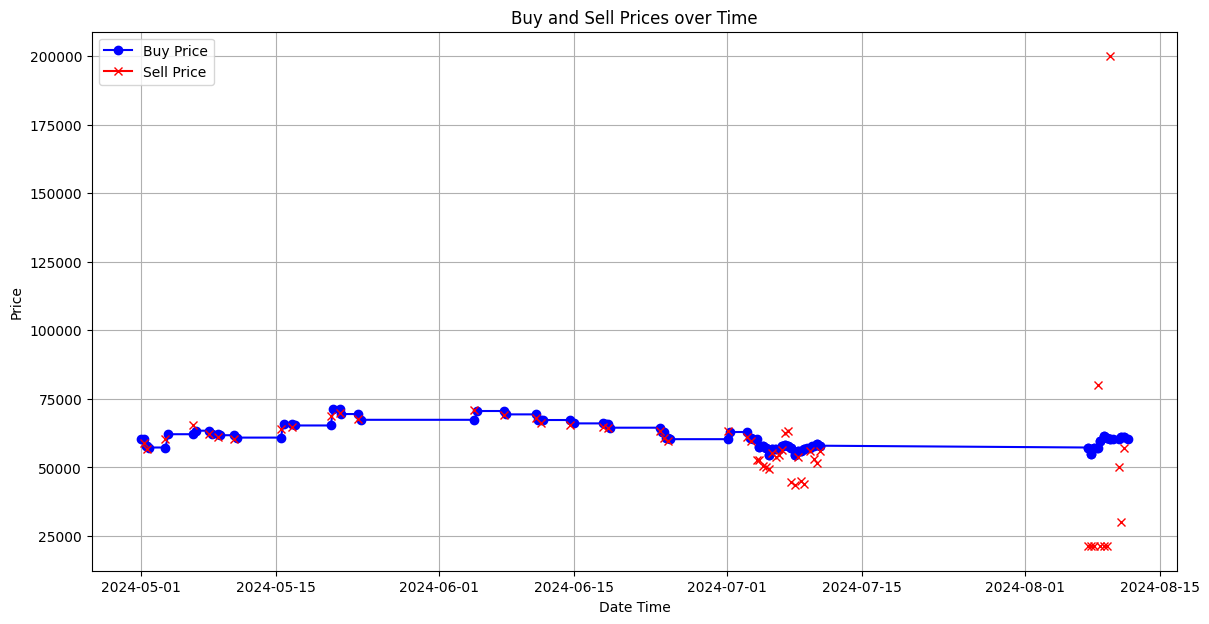

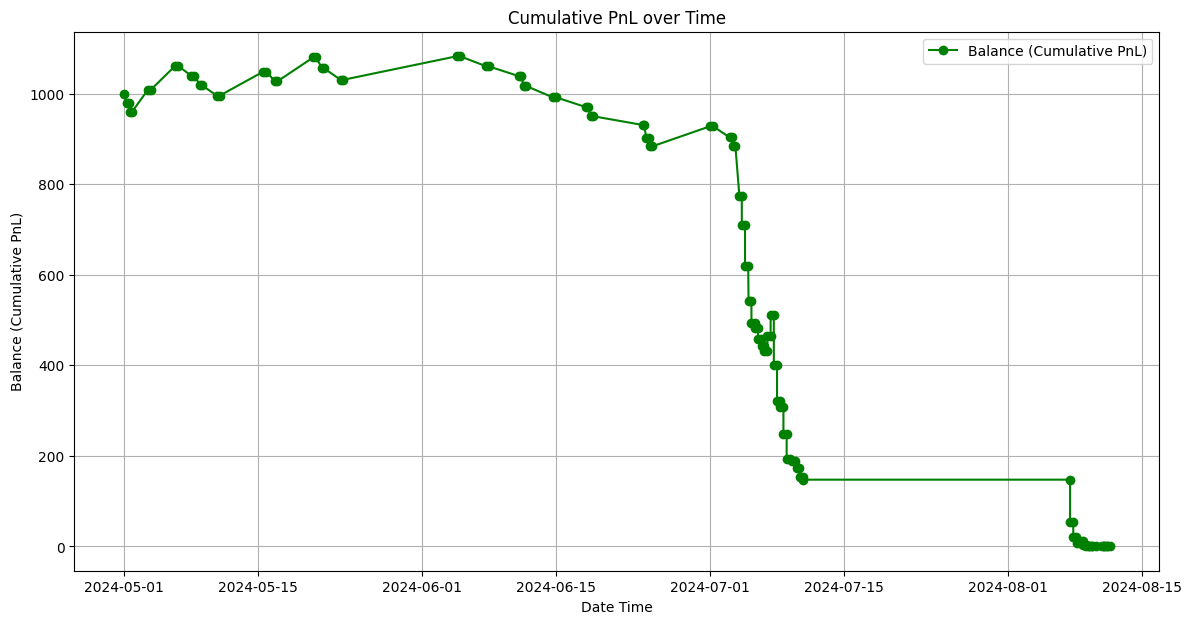

In [33]:
import matplotlib.pyplot as plt

def visualize_ledger(ledger_df):
    # Ensure date_time is in datetime format for proper plotting
    result['date_time'] = pd.to_datetime(result['date_time'])

    # Plotting the Buy and Sell Prices
    plt.figure(figsize=(14, 7))
    
    plt.plot(result['date_time'], result['buy_price'], label='Buy Price', marker='o', linestyle='-', color='blue')
    plt.plot(result['date_time'], result['sell_price'], label='Sell Price', marker='x', linestyle='-', color='red')
    
    plt.xlabel('Date Time')
    plt.ylabel('Price')
    plt.title('Buy and Sell Prices over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the Balance (Cumulative PnL)
    plt.figure(figsize=(14, 7))
    
    plt.plot(result['date_time'], result['balance'], label='Balance (Cumulative PnL)', marker='o', linestyle='-', color='green')
    
    plt.xlabel('Date Time')
    plt.ylabel('Balance (Cumulative PnL)')
    plt.title('Cumulative PnL over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ensure you run the ledger function first and store the result in ledger_df
result = ledger(temp1, temp2)

# Now visualize the ledger data
visualize_ledger(result)
